In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
# For modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from tqdm.notebook import tqdm
from matplotlib.colors import ListedColormap
#sns.set_palette('viridis')
pd.options.mode.chained_assignment = None  # Supress warning, default='warn'

# Read Data
In this section we read the data (pickle file) after the preprocessing from the preprocessing notebook/part

In [2]:
df = pd.read_pickle('../data/preprocessed/accepted_df_preprocessed.pkl')
print(f"Shape of df: {df.shape}")
df.head(5)

Shape of df: (1345310, 101)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,3600.0,3600.0,3600.0,36,13.99,123.03,C,C4,10.0,MORTGAGE,...,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,24700.0,24700.0,24700.0,36,11.99,820.28,C,C1,10.0,MORTGAGE,...,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,20000.0,20000.0,20000.0,60,10.78,432.66,B,B4,10.0,MORTGAGE,...,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
4,10400.0,10400.0,10400.0,60,22.45,289.91,F,F1,3.0,MORTGAGE,...,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N
5,11950.0,11950.0,11950.0,36,13.44,405.18,C,C3,4.0,RENT,...,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,N,Cash,N


# TAKE SUBSAMPLE OF DATA FOR COMPUTATION ISSUES (TODO: DELETE THIS LATER)

In [3]:
df = df.sample(frac = 0.1)
print(df.shape)

(134531, 101)


# Model Preprocessing: Encode Features from categorical to numerical
In this section we prepare our data set for modeling through fixing the inbalancement of our data, encoding categorical data, dropping features that are only apriori the application known etc...

## Drop columns for prediction
In this small section we drop features that we do not have prior the lending application. We consulted the data dictionary table and analyzed which columns to keep and which to drop. Note that this requires a lot of domain knowledge.

In [4]:
keep_list = ['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']

cols_to_drop = [col for col in df.columns if col not in keep_list]
print(f"Cols to drop: {cols_to_drop}")
df.drop(cols_to_drop, axis=1, inplace=True)
print(f"Shape of df after drop: {df.shape}")

Cols to drop: ['funded_amnt', 'funded_amnt_inv', 'pymnt_plan', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever

In [5]:
# Preview categorical data
print(df.dtypes.value_counts())
# Get categorical columns names
cat_columns = df.select_dtypes(include=['object']).columns.tolist()
# Preview
print(cat_columns)

float64    15
object      9
int32       1
dtype: int64
['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type']


### Deleted irrelevant categorical features
Delete categorical features that are not relevant for the Modelling or contain too many realization so that encoding them would be infeasible.

In [6]:
# Define categorical columns from cat_columns to keep here
CAT_COLS_TO_KEEP = ["term", "home_ownership", "grade", "verification_status", "application_type", "initial_list_status"]
CAT_COLS_TO_DROP = [col for col in cat_columns if col not in CAT_COLS_TO_KEEP]

print(f"Categorical Columns to drop: {CAT_COLS_TO_DROP}\n")
print(f"Shape of df before columns drop: {df.shape}")
# Drop irrelevant categorical features
df.drop(CAT_COLS_TO_DROP, axis=1, inplace=True)
print(f"Shape of df after columns drop: {df.shape}")

Categorical Columns to drop: ['sub_grade', 'purpose', 'addr_state']

Shape of df before columns drop: (134531, 25)
Shape of df after columns drop: (134531, 22)


## Preview of the remaining categorical features

In [7]:
print(df.dtypes.value_counts())
df.select_dtypes("object")

float64    15
object      6
int32       1
dtype: int64


,term,grade,home_ownership,verification_status,initial_list_status,application_type
277632,60,B,MORTGAGE,Source Verified,f,Individual
1830942,36,D,RENT,Verified,f,Individual
44356,36,B,MORTGAGE,Source Verified,w,Individual
54272,36,D,RENT,Verified,w,Individual
1648595,36,B,RENT,Source Verified,f,Individual
...,...,...,...,...,...,...
256228,60,G,MORTGAGE,Verified,w,Individual
1646286,36,A,RENT,Not Verified,f,Individual
1796024,60,C,OWN,Verified,f,Individual
1920622,36,B,MORTGAGE,Not Verified,f,Individual


## Create Dummy Variables

In [8]:
# Binary Encoding
import category_encoders as ce
encoder = ce.BinaryEncoder(cols=CAT_COLS_TO_KEEP)
df_binary = encoder.fit_transform(df)
# check
df_binary.dtypes.value_counts()

float64    15
int64      14
int32       1
dtype: int64

In [9]:
# Convert all values to float
df_binary = df_binary.astype(float)
df_binary.dtypes.value_counts()

float64    30
dtype: int64

## Preview preprocessed dataframe:

In [10]:
df_binary.head(10)

,loan_amnt,term_0,term_1,int_rate,installment,grade_0,grade_1,grade_2,emp_length,home_ownership_0,...,pub_rec,revol_bal,revol_util,total_acc,initial_list_status_0,initial_list_status_1,application_type_0,application_type_1,mort_acc,pub_rec_bankruptcies
277632,21000.0,0.0,1.0,8.18,427.62,0.0,0.0,1.0,NaN,0.0,...,0.0,59380.0,10.3,35.0,0.0,1.0,0.0,1.0,1.0,0.0
1830942,10625.0,1.0,0.0,18.25,385.46,0.0,1.0,0.0,10.0,0.0,...,0.0,6521.0,58.2,11.0,0.0,1.0,0.0,1.0,0.0,0.0
44356,11625.0,1.0,0.0,10.99,380.54,0.0,0.0,1.0,10.0,0.0,...,0.0,11647.0,48.6,51.0,1.0,0.0,0.0,1.0,1.0,0.0
54272,5000.0,1.0,0.0,15.41,174.34,0.0,1.0,0.0,1.0,0.0,...,0.0,1254.0,26.7,8.0,1.0,0.0,0.0,1.0,0.0,0.0
1648595,19200.0,1.0,0.0,11.89,636.75,0.0,0.0,1.0,1.0,0.0,...,0.0,14006.0,20.3,26.0,0.0,1.0,0.0,1.0,NaN,0.0
215297,35000.0,0.0,1.0,17.57,880.61,0.0,1.0,0.0,1.0,0.0,...,0.0,26598.0,95.7,18.0,0.0,1.0,0.0,1.0,0.0,0.0
88229,18000.0,0.0,1.0,19.99,476.79,0.0,1.0,1.0,10.0,0.0,...,0.0,31870.0,90.8,32.0,1.0,0.0,0.0,1.0,1.0,0.0
1490588,20000.0,0.0,1.0,25.81,596.57,0.0,1.0,1.0,8.0,0.0,...,0.0,19304.0,41.8,34.0,1.0,0.0,0.0,1.0,2.0,0.0
2178253,5600.0,1.0,0.0,7.49,174.17,1.0,0.0,0.0,10.0,0.0,...,0.0,2691.0,22.8,14.0,1.0,0.0,0.0,1.0,2.0,0.0
1209184,33575.0,1.0,0.0,16.99,1196.88,0.0,1.0,0.0,6.0,0.0,...,1.0,15734.0,39.2,23.0,1.0,0.0,0.0,1.0,0.0,0.0


## Create Balanced Data Set via Downsampling

0.0    107901
1.0     26630
Name: loan_status, dtype: int64
(134531, 30)


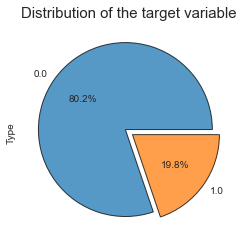

In [11]:
print(df_binary.loan_status.value_counts())
print(df_binary.shape)

plt.title("Distribution of the target variable", size=15)
df_binary.groupby('loan_status').size().plot(kind='pie', y = "loan_status",
                                             label = "Type", autopct='%1.1f%%',
                                             wedgeprops = {"edgecolor": "black", "alpha": 0.75},
                                             explode = [0.05, 0.05])
plt.show()

0.0    34619
1.0    26630
Name: loan_status, dtype: int64


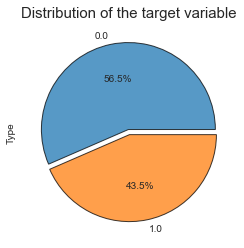

In [12]:
# Downsampling
loan_status_0 = df_binary[df_binary["loan_status"] == 0.0]
loan_status_1  = df_binary[df_binary["loan_status"] == 1.0]

loan_status_0_downsample = resample(loan_status_0,
             replace=True,
             n_samples=round(1.3*len(loan_status_1)),
             random_state=42)

df_binary_downsampled = pd.concat([loan_status_0_downsample, loan_status_1])

print(df_binary_downsampled["loan_status"].value_counts())
# Plot settings
plt.title("Distribution of the target variable", size=15)
df_binary_downsampled.groupby('loan_status').size().plot(kind='pie', y = "loan_status",
                                             label = "Type", autopct='%1.1f%%',
                                             wedgeprops = {"edgecolor": "black", "alpha": 0.75},
                                             explode = [0.03, 0.03])
plt.show()

## Data Imputation
Since we still have some NaNs in our feature, we replace them by taking the median values.

In [13]:
# Fill NaNs with Median
df_binary_downsampled = df_binary_downsampled.fillna(df_binary_downsampled.median())
# Preview
df_binary_downsampled.head(5)

,loan_amnt,term_0,term_1,int_rate,installment,grade_0,grade_1,grade_2,emp_length,home_ownership_0,...,pub_rec,revol_bal,revol_util,total_acc,initial_list_status_0,initial_list_status_1,application_type_0,application_type_1,mort_acc,pub_rec_bankruptcies
1272707,5000.0,1.0,0.0,11.67,165.29,0.0,0.0,1.0,7.0,0.0,...,3.0,3756.0,38.7,33.0,0.0,1.0,0.0,1.0,0.0,0.0
629352,10000.0,1.0,0.0,9.93,322.35,0.0,0.0,1.0,2.0,0.0,...,0.0,19923.0,50.8,20.0,1.0,0.0,0.0,1.0,0.0,0.0
983079,22775.0,0.0,1.0,28.69,718.63,1.0,1.0,0.0,10.0,0.0,...,0.0,12451.0,44.6,31.0,1.0,0.0,0.0,1.0,3.0,0.0
1213544,13000.0,0.0,1.0,12.49,292.41,0.0,0.0,1.0,1.0,0.0,...,0.0,12018.0,55.1,17.0,1.0,0.0,0.0,1.0,0.0,0.0
1757985,8000.0,1.0,0.0,13.53,271.60,0.0,0.0,1.0,10.0,0.0,...,0.0,29291.0,67.3,24.0,1.0,0.0,0.0,1.0,3.0,0.0


## Data Split
In this section we split the data into a training and test set. The corresponding model is then trained on the training set and tested on the test set.

In [14]:
# Fraction of test data
TEST_SIZE = 0.3

X = df_binary_downsampled.drop("loan_status", axis=1)
y = df_binary_downsampled["loan_status"]

# Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42, stratify=y)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (42874, 29)
Shape of X_test: (18375, 29)
Shape of y_train: (42874,)
Shape of y_test: (18375,)


## Scaling
We scale the data with the MinMaxScaler to a range of $[0, 1]$

In [15]:
# Init object
scaler = MinMaxScaler()
# Scale X_train
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)
# Scale X_test
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled)

# Preview X_train_scaled
X_train_scaled.head(10)

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.455769,0.0,1.0,0.385903,0.251515,1.0,0.0,1.0,0.6,0.0,...,0.0,0.000000,0.000000,0.201613,1.0,0.0,0.0,1.0,0.054054,0.0
1,0.641026,1.0,0.0,0.247664,0.494356,0.0,0.0,1.0,1.0,0.0,...,0.0,0.025600,0.624509,0.096774,1.0,0.0,0.0,1.0,0.027027,0.0
2,0.128205,0.0,1.0,0.196651,0.062116,0.0,0.0,1.0,0.0,0.0,...,0.0,0.012028,0.601573,0.056452,0.0,1.0,0.0,1.0,0.027027,0.0
3,0.179487,1.0,0.0,0.460670,0.155095,0.0,1.0,0.0,0.6,0.0,...,0.0,0.011189,0.307339,0.193548,0.0,1.0,0.0,1.0,0.000000,0.0
4,0.182051,1.0,0.0,0.401090,0.153581,0.0,1.0,0.0,0.6,0.0,...,0.0,0.002605,0.359109,0.177419,0.0,1.0,0.0,1.0,0.081081,0.0
5,0.615385,1.0,0.0,0.350467,0.493604,1.0,0.0,1.0,1.0,0.0,...,0.0,0.007451,0.541284,0.153226,1.0,0.0,0.0,1.0,0.081081,0.0
6,0.057692,1.0,0.0,0.042056,0.044908,1.0,0.0,0.0,1.0,0.0,...,0.0,0.000872,0.099607,0.217742,0.0,1.0,0.0,1.0,0.027027,0.0
7,0.128205,1.0,0.0,0.188474,0.100838,0.0,0.0,1.0,1.0,0.0,...,0.0,0.009133,0.134338,0.233871,0.0,1.0,0.0,1.0,0.081081,0.0
8,0.128205,1.0,0.0,0.045950,0.094830,1.0,0.0,0.0,0.7,0.0,...,0.0,0.010507,0.167104,0.120968,1.0,0.0,0.0,1.0,0.027027,0.0
9,0.487179,1.0,0.0,0.139798,0.361649,1.0,0.0,0.0,0.7,0.0,...,0.0,0.020356,0.357143,0.096774,0.0,1.0,0.0,1.0,0.054054,0.0


---
# Task 3: Logistic Regression In Sample
Use logistic regression (in-sample) for default prediction. Interpret your results for logistic regression

In [16]:
# Fit Model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

# Predict In Sample
y_pred = lr.predict(X_train_scaled)

## Test Model

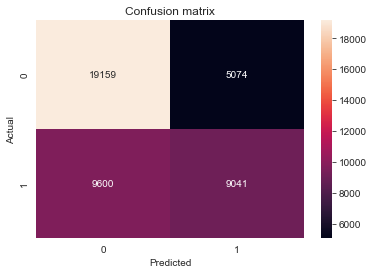

________________________________________________________________________________
              precision    recall  f1-score   support

         0.0       0.67      0.79      0.72     24233
         1.0       0.64      0.49      0.55     18641

    accuracy                           0.66     42874
   macro avg       0.65      0.64      0.64     42874
weighted avg       0.66      0.66      0.65     42874

Information:
Precision: Percentage of correct positive predictions relative to total positive predictions
Recall: Percentage of correct positive predictions relative to total actual positives.
F1 Score: A weighted harmonic mean of precision and recall. The closer to 1, the better the model.
________________________________________________________________________________


In [17]:
# Plot Confusion matrics
cm = confusion_matrix(y_true=y_train, y_pred=y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot classification report
print(80 * "_")
print(classification_report(y_true=y_train, y_pred=y_pred))
print("Information:")
print("Precision: Percentage of correct positive predictions relative to total positive predictions")
print("Recall: Percentage of correct positive predictions relative to total actual positives.")
print("F1 Score: A weighted harmonic mean of precision and recall. The closer to 1, the better the model.")
print(80 * "_")

---
# Task 4: Compare different classification models
Comparing
* logistic regression,
* classification tree,
* random forest,
* bagging,
* support vector machine (with two kernel functions),
* and neural network
for default prediction based on the out-of-sample performance measures (at least three different measures).

In [ ]:
%%time
models = []

models.append(("LogisticRegression",LogisticRegression(fit_intercept=True, max_iter=1000, solver="saga")))
models.append(("DecisionTree",DecisionTreeClassifier()))
models.append(("RandomForest",RandomForestClassifier()))
models.append(("BaggingCLF",BaggingClassifier()))
models.append(("SVC_rbf",SVC(kernel='rbf')))
models.append(("SVC_linear",SVC(kernel="linear")))
models.append(("NeuronalNetwork", MLPClassifier(alpha=1, max_iter=1000)))

results = []
names = []
for name, model in tqdm(models):
    result = cross_val_score(model, X_train_scaled, y_train,  cv=3, n_jobs=-1)
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# Boxplot algorithm comparison
fig = plt.figure(figsize=(15,7))
fig.suptitle('Algorithm Comparison', size=16)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()